# コサイン類似度を利用したログ異常検知
事前に異常となるログを用意しておけば、それに似た異常をログから検出する。

# Import

In [1]:
# import
import os
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
import load_log
from data_preprocessing import FeatureExtraction

# Config

In [2]:
class Config:
    log_path = "./data/bgl/BGL_2k.log"
    output_dir = "./model/"
config = Config

In [3]:
df = load_log.load_bgl(config)
display(df)

,log,log(after),label,category
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,RAS KERNEL INFO instruction cache parity error...,0,normal
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,NE NE RAS KERNEL INFO double hummer alignment ...,0,normal
...,...,...,...,...
1995,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-22.3...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1996,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1997,2005.12.26 R37-M1-NC-C:J02-U11 2005-12-26-23.4...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal
1998,2005.12.27 R37-M1-NC-C:J02-U11 2005-12-27-01.2...,NC NC RAS KERNEL INFO instruction cache parity...,0,normal


In [4]:
# 各データの異常件数
df_info = df.groupby(["label", "category"]).size()
df_info = pd.DataFrame(df_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 全データの異常別件数 + -----")
display(df_info)

 ----- + 全データの異常別件数 + -----


count
label category       
1     KERNDTLB     60
      KERNSTOR     30
      APPSEV       17
      KERNMNTF     11
      KERNTERM      7
      KERNREC       5
      APPRES        4
      APPREAD       3
      APPTO         2
      KERNRTSP      2
      APPCHILD      1
      APPOUT        1
0     normal     1857

# 異常の登録
異常の各カテゴリのデータを1つずつ抽出する。
   * `登録した異常のラベル`    : -1
   * `未登録の異常ログのラベル`: 1
   * `(未登録の)正常ログのラベル`        : 0

In [5]:
# 異常データ/正常データの分割
normal_df = df[df["label"] == 0]
anomaly_df = df[df["label"] == 1]
# 各カテゴリから異常を一件抽出
KERNDTLB = anomaly_df[anomaly_df["category"] == "KERNDTLB"].head(1)
anomaly_df = anomaly_df.drop(KERNDTLB.index[0], axis=0)
KERNSTOR = anomaly_df[anomaly_df["category"] == "KERNSTOR"].head(1)
anomaly_df = anomaly_df.drop(KERNSTOR.index[0], axis=0)
APPSEV = anomaly_df[anomaly_df["category"] == "APPSEV"].head(1)
anomaly_df = anomaly_df.drop(APPSEV.index[0], axis=0)
KERNMNTF = anomaly_df[anomaly_df["category"] == "KERNMNTF"].head(1)
anomaly_df = anomaly_df.drop(KERNMNTF.index[0], axis=0)
KERNTERM = anomaly_df[anomaly_df["category"] == "KERNTERM"].head(1)
anomaly_df = anomaly_df.drop(KERNTERM.index[0], axis=0)
KERNREC = anomaly_df[anomaly_df["category"] == "KERNREC"].head(1)
anomaly_df = anomaly_df.drop(KERNREC.index[0], axis=0)
APPRES = anomaly_df[anomaly_df["category"] == "APPRES"].head(1)
anomaly_df = anomaly_df.drop(APPRES.index[0], axis=0)
APPREAD = anomaly_df[anomaly_df["category"] == "APPREAD"].head(1)
anomaly_df = anomaly_df.drop(APPREAD.index[0], axis=0)
APPTO = anomaly_df[anomaly_df["category"] == "APPTO"].head(1)
anomaly_df = anomaly_df.drop(APPTO.index[0], axis=0)
KERNRTSP = anomaly_df[anomaly_df["category"] == "KERNRTSP"].head(1)
anomaly_df = anomaly_df.drop(KERNRTSP.index[0], axis=0)
APPCHILD = anomaly_df[anomaly_df["category"] == "APPCHILD"].head(1)
anomaly_df = anomaly_df.drop(APPCHILD.index[0], axis=0)
APPOUT = anomaly_df[anomaly_df["category"] == "APPOUT"].head(1)
anomaly_df = anomaly_df.drop(APPOUT.index[0], axis=0)
# ラベル用異常データの生成
registered_log = pd.concat([KERNDTLB, KERNSTOR,APPSEV, KERNMNTF, KERNTERM, KERNREC, APPRES, APPREAD, APPTO, KERNRTSP, APPCHILD, APPOUT])
registered_log["label"] = -1  # ラベルは-1とする。
# 学習/推論のデータ分割
analysis_log = pd.concat([normal_df, anomaly_df])

In [6]:
# 各データの異常件数
registered_log_info = registered_log.groupby(["label", "category"]).size()
registered_log_info = pd.DataFrame(registered_log_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 登録した異常別件数 + -----")
display(registered_log_info)

analysis_log_info = analysis_log.groupby(["label", "category"]).size()
analysis_log_info = pd.DataFrame(analysis_log_info).rename(columns={0:"count"}).sort_values(["label", "count"], ascending=False)
print(" ----- + 解析するデータの異常別件数 + -----")
display(analysis_log_info)

 ----- + 登録した異常別件数 + -----


count
label category       
-1    APPCHILD      1
      APPOUT        1
      APPREAD       1
      APPRES        1
      APPSEV        1
      APPTO         1
      KERNDTLB      1
      KERNMNTF      1
      KERNREC       1
      KERNRTSP      1
      KERNSTOR      1
      KERNTERM      1

 ----- + 解析するデータの異常別件数 + -----


count
label category       
1     KERNDTLB     59
      KERNSTOR     29
      APPSEV       16
      KERNMNTF     10
      KERNTERM      6
      KERNREC       4
      APPRES        3
      APPREAD       2
      APPTO         1
      KERNRTSP      1
0     normal     1857

In [7]:
# 特徴量抽出(TF-ILF)
all_log = pd.concat([registered_log, analysis_log])
feature, vocabulary = FeatureExtraction(all_log["log(after)"].values, config, mode="train", fe_type="tfilf")()
feature[["log","category", "label"]] = all_log[["log", "category", "label"]].values

In [8]:
analysis_feature = feature[feature["label"] != -1]
registed_feature = feature[feature["label"] == -1]
display(analysis_feature)
display(registed_feature)

,0,1,2,3,4,5,6,7,8,9,...,477,478,479,480,481,482,483,log,category,label
12,3.578531,3.578531,0.000000,0.0,0.0,1.636895,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0
13,3.578531,3.578531,0.000000,0.0,0.0,1.636895,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0
14,3.578531,3.578531,0.000000,0.0,0.0,1.636895,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0
15,3.578531,3.578531,0.000000,0.0,0.0,1.636895,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,0
16,3.578531,3.578531,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3.578531,3.578531,3.578531,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,4.266716,2005.12.04 R46-M0-N8-I:J18-U11 2005-12-04-12.0...,KERNMNTF,1
1996,3.578531,0.000000,3.578531,0.0,0.0,0.000000,0.0,0.0,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.12.13 R74-M1-N8-I:J18-U11 2005-12-13-09.5...,APPSEV,1
1997,3.578531,0.000000,3.578531,0.0,0.0,0.000000,0.0,0.0,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.12.13 R44-M0-N4-I:J18-U01 2005-12-13-09.5...,APPSEV,1
1998,3.578531,0.000000,3.578531,0.0,0.0,0.000000,0.0,0.0,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2005.12.14 R37-M1-N8-I:J18-U11 2005-12-14-23.1...,APPSEV,1


,0,1,2,3,4,5,6,7,8,9,...,477,478,479,480,481,482,483,log,category,label
0,3.578531,3.578531,3.578531,3.174726,4.266716,1.636895,2.483241,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.11 R30-M0-N9-C:J16-U01 2005-06-11-17.3...,KERNDTLB,-1
1,3.578531,3.578531,3.578531,3.174726,0.000000,0.000000,2.483241,3.578531,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.13 R10-M1-N5-C:J15-U11 2005-06-13-17.3...,KERNSTOR,-1
2,3.578531,0.000000,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.14 R21-M0-N8-I:J18-U11 2005-08-14-19.0...,APPSEV,-1
3,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.08.31 R42-M1-NC-I:J18-U11 2005-08-31-22.2...,KERNMNTF,-1
4,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.18 R20-M1-N8-C:J12-U01 2005-07-18-15.5...,KERNTERM,-1
5,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.10.28 R63-M1-N5-C:J17-U01 2005-10-28-13.0...,KERNREC,-1
6,3.578531,0.000000,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.11.21 R13-M1-N4-I:J18-U11 2005-11-21-13.4...,APPRES,-1
7,3.578531,0.000000,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.2...,APPREAD,-1
8,3.578531,0.000000,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,3.578531,3.578531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.11.21 R14-M0-NC-I:J18-U11 2005-11-21-11.0...,APPTO,-1
9,3.578531,3.578531,3.578531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.07.11 R01-M0-N1-C:J09-U11 2005-07-11-14.0...,KERNRTSP,-1


In [9]:
# 全ログと各異常ログの類似度から異常を抽出
all_proba_lict = []
for row_feature in analysis_feature.values:
    proba_dict = {}
    analysis_row = row_feature[:-3]
    for anomaly_feature in registed_feature.values:
        category = anomaly_feature[-2]
        anomaly_row = anomaly_feature[:-3]
        anom_proba = np.dot(analysis_row, anomaly_row) / (np.linalg.norm(analysis_row) * np.linalg.norm(anomaly_row))
        proba_dict[category] = anom_proba
    max_kv = list(max(proba_dict.items(), key=lambda x: x[1]))
    if max_kv[1] <= 0.75:
        max_kv[0] = "normal"
    all_proba_lict.append(max_kv)
all_proba = pd.DataFrame(all_proba_lict, columns=["category_pred", "proba"])
all_proba["category"] = analysis_feature["category"].values
all_proba["log"] = analysis_feature["log"].values
all_proba = all_proba[["log", "category","category_pred","proba"]]

# 結果表示

In [10]:
all_proba

,log,category,category_pred,proba
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,normal,0.381521
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,normal,0.381521
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,normal,0.381521
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.4...,normal,normal,0.381521
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.4...,normal,normal,0.271464
...,...,...,...,...
1983,2005.12.04 R46-M0-N8-I:J18-U11 2005-12-04-12.0...,KERNMNTF,normal,0.659174
1984,2005.12.13 R74-M1-N8-I:J18-U11 2005-12-13-09.5...,APPSEV,APPSEV,0.959183
1985,2005.12.13 R44-M0-N4-I:J18-U01 2005-12-13-09.5...,APPSEV,APPSEV,0.959183
1986,2005.12.14 R37-M1-N8-I:J18-U11 2005-12-14-23.1...,APPSEV,APPSEV,0.959183


# 混同行列表示

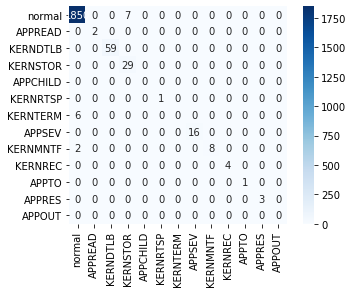

In [11]:
all_proba_plt = all_proba.copy()
category_keys = df["category"].unique()
category_values = [i for i in range(len(category_keys))]
category_dict = dict(zip(category_keys, category_values))
all_proba["category_pred"] = all_proba["category_pred"].map(category_dict)
all_proba["category"] = all_proba["category"].map(category_dict)
# スコア表示
cm = confusion_matrix(all_proba["category"].values, all_proba["category_pred"].values, labels=category_values)
cm_df = pd.DataFrame(data=cm,index=category_dict.keys(), columns=category_dict.keys())
sns.heatmap(cm_df, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()

# ログの可視化

In [12]:
# 異常ログの可視化
test_tmp = all_proba_plt.copy()
# test_tmp["y_true"] = test_ilf["label"].values
# test_tmp["y_pred"] = y_pred_ilf
# test_tmp = test_tmp[["log", "y_pred", "y_true"]].reset_index()
#del test_tmp["index"]
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
test_tmp.style.apply(highlight_greaterthan, threshold=0.75, column=['proba'], axis=1)

,log,category,category_pred,proba
0,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected,normal,normal,0.381521
1,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.53.276129 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected,normal,normal,0.381521
2,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.49.36.156884 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected,normal,normal,0.381521
3,2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.49.38.026704 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected,normal,normal,0.381521
4,2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.47.20.730545 R23-M0-NE-C:J05-U01 RAS KERNEL INFO 63543 double-hummer alignment exceptions,normal,normal,0.271464
5,2005.06.03 R24-M0-N1-C:J13-U11 2005-06-03-16.56.14.254137 R24-M0-N1-C:J13-U11 RAS KERNEL INFO 162 double-hummer alignment exceptions,normal,normal,0.347078
6,2005.06.03 R21-M1-N6-C:J08-U11 2005-06-03-16.56.55.309974 R21-M1-N6-C:J08-U11 RAS KERNEL INFO 141 double-hummer alignment exceptions,normal,normal,0.347078
7,"2005.06.03 R16-M1-N2-C:J17-U01 2005-06-03-18.21.59.871925 R16-M1-N2-C:J17-U01 RAS KERNEL INFO CE sym 2, at 0x0b85eee0, mask 0x05",normal,normal,0.337856
8,"2005.06.04 R30-M0-N7-C:J08-U01 2005-06-04-20.28.40.767551 R30-M0-N7-C:J08-U01 RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask 0x40",normal,normal,0.337856
9,2005.06.05 R25-M0-N7-C:J02-U01 2005-06-05-00.09.01.903373 R25-M0-N7-C:J02-U01 RAS KERNEL INFO generating core.2275,normal,normal,0.408275
